In [3]:
%pip install pyalex

In [5]:
import pandas as pd, networkx as nx, numpy as np, matplotlib.pyplot as plt
import matplotlib.patheffects as patheffects
import random,time,itertools,tqdm,collections
from sklearn.feature_extraction.text import TfidfVectorizer
from networkx.drawing.nx_agraph import graphviz_layout
import re
from pyalex import Works, Authors, Sources, Institutions,Topics, Concepts, Funders
import pyalex,pandas as pd, numpy as np, matplotlib.pyplot as plt
import matplotlib.patheffects as patheffects
import random,time,itertools,tqdm,collections
import string
import re
import nltk
import tqdm
import requests
from bs4 import BeautifulSoup
import pickle

flatten = lambda x: list(itertools.chain.from_iterable(x))

pyalex.config.email = "your_mail_adress" # ここにあなたのメールアドレスを入力してください

from pyalex import config

config.max_retries = 3  # 最大再試行数を 3 回に設定
config.retry_backoff_factor = 1  # 再試行間隔を 0.1 秒に設定
config.retry_http_codes = [429, 500, 503]  # 再試行を行う HTTP エラーコードを指定

In [8]:
def getAll(pyalexObj):
    pager = pyalexObj.paginate(per_page=200,n_max=None)
    arr = []
    for page in tqdm.tqdm(pager):
        arr += page
    return arr

def get_tab20_color_hex(index):
    if index!=index:
        return None
    cmap = plt.get_cmap('tab20')
    actual_index = index % 20
    rgb_color = cmap(int(actual_index))[:3]  # Ignore the alpha value
    hex_color = '#%02x%02x%02x' % (int(rgb_color[0]*255), int(rgb_color[1]*255), int(rgb_color[2]*255))
    return hex_color

def get_journal_name_original(citing):
    '''
    citnig(列)：['primary_location']列しか取れない

    '''
    try:
        return citing['source']['display_name']
    except:
        return None

def get_topic(topic_raw,class_):
    '''
    topic()：['primary_location']列しか取れない
    class(str):domain,field,subfieldから選ぶ
    '''

    if class_ == "domain":
        try:
          return topic_raw['domain']["display_name"]

        except:
          return None

    elif class_ == "field":
        try:
          return topic_raw['field']["display_name"]

        except:
          return None

    elif class_ == "subfield":

        try:
         return topic_raw['subfield']["display_name"]

        except:
          return None



def remove_parentheses(text):
    """
    文字列から()で囲まれた部分を含む文字列を削除し、
    ()の前に半角スペースがある場合、そのスペースも削除する関数

    Parameters:
        text (str): 対象の文字列

    Returns:
        str: ()で囲まれた部分が削除された文字列
    """
    return re.sub(r'\s*\([^()]*\)', '', text)

def remove_parentheses(text):
    # 正規表現を使って()で囲まれた部分を検索し、削除する
    result = re.sub(r'\([^)]*\)', '', text)
    return result.strip()  # 削除後に余分な空白を削除して返す

def fetch_json_data(url):

    retries = 5

    '''
    url(str):APIのURL
    json_data(json):論文のデータ
    '''

    for _ in range(retries):

      try:
          response = requests.get(url)
          # ステータスコードが200以外の場合はエラーを発生させます
          response.raise_for_status()
          # JSONデータを取得します
          json_data = response.json()

          break

      except Exception as e:
            print(f"エラーが発生しました: {e}")
            print("リトライします...")
            time.sleep(5)
            continue

    return json_data


def fetch_all_results(url):
    url += "&per-page=200"
    results = []

    # リトライ回数
    retries = 5

    for _ in range(retries):
        try:
            # 初回のリクエストでカーソルを取得
            response = requests.get(url + "&cursor=*")
            data = response.json()

            # レスポンスから結果を取得
            if "results" in data:
                results += data["results"]

            # ページング情報を更新
            while "meta" in data and "next_cursor" in data["meta"]:
                next_cursor = data["meta"]["next_cursor"]
                response = requests.get(url + f"&cursor={next_cursor}")
                data = response.json()

                # レスポンスから結果を取得
                if "results" in data:
                    results += data["results"]

            # エラーが起きなかった場合はループを抜ける
            break
        except Exception as e:
            print(f"エラーが発生しました: {e}")
            print("リトライします...")
            time.sleep(5)
            continue

    return results




#journal
def get_journal_topic(url):
  api_url = "https://api.openalex.org/works/" + url.split("/")[-1]
  inf = fetch_json_data(api_url)
  journal = get_journal_name_original(inf["primary_location"])
  #たまにtopic列がないやつの方があるからtry文をかませる
  try:
    field = get_topic(inf["primary_topic"], class_="field")
    subfield = get_topic(inf["primary_topic"], class_="subfield")
  except Exception as error:
      field = None
      subfield = None

  return journal, field, subfield


In [11]:
journal_colors = {
    'SciMet': '#000080',  # ネイビー
    'SSS': '#ff7f0e',  # オレンジ
    'RePoli': '#2ca02c',  # 緑
    'STHV': '#d62728',  # 赤
    'TechNov': '#9467bd',  # 紫
    'PUS': '#8c564b',  # 茶
    'Minerva': '#e377c2',  # ピンク
    'SciCom': '#7f7f7f',  # グレー
    'SasC': '#bcbd22',  # 黄緑
    'ReEval': '#17becf',  # 水色
    'STS': '#ff9896',  # ピンク
    'JRI': '#1f77b4',  # 青
    'EASTS': '#ffbb78',  # ピーチ
    'TIS': 'teal',  # ディール
    'SPP': 'olive',  # オリーブ
    'JCOM': 'darkolivegreen'  # ダークグリーン
}

cols = ["id","authorships",'title',"publication_year","referenced_works","cited_by_count","primary_topic","primary_location","abstract_inverted_index"]

source_ids = [
    ##STS系
    "https://openalex.org/sources/s202144432", # Science, technology & society
    "https://openalex.org/sources/s2181421",   # Science, technology & human values
    "https://openalex.org/sources/s68632876",  # Social studies of science
    "https://openalex.org/sources/s104981805", # East Asian science, technology and society
    "https://openalex.org/sources/s190143089", # Science as culture
    "https://openalex.org/sources/s205537954", # Minerva
    #コミュニケーション系
    "https://openalex.org/sources/s124907306", # Public understanding of science
    "https://openalex.org/sources/s30803906",  # JCOM, journal of science communication
    "https://openalex.org/sources/s4210212669",# Science communication
    #計量系
    "https://openalex.org/sources/s16793705",  # Research Evaluation
    "https://openalex.org/sources/s9731383",   # Research policy
    "https://openalex.org/sources/s4210168539",# Science and public policy
    "https://openalex.org/sources/s148561398", # scientometorics
    #テクノロジー
    "https://openalex.org/sources/s70698675",  # technovation
    "https://openalex.org/sources/s149100181", # Technology in society
    "https://openalex.org/sources/s2764399430" # Journal of Responsible Innovation


]

In [18]:
#全てのSTS論文
THRESHOLD = 1
pyalexObj = Works().filter(locations={"source":{"id":"|".join(source_ids)}}, cited_by_count=f">{THRESHOLD-1}",has_references="true").select(cols)
field_count = pyalexObj.count()
print(field_count)
works =  pd.DataFrame(getAll(pyalexObj)).drop_duplicates(subset=['id'])
print(f"取得した論文数/分野内の論文数：{len(works)}/{field_count} ({round(len(works)/field_count*100,2)}%)" )



25904


131it [00:34,  3.79it/s]


取得した論文数/分野内の論文数：25903/25904 (100.0%)


In [20]:
#元データの生成方法
df =works

#参考文献の数
for i in range(df.shape[0]):
    referenced_works = df.loc[i, "referenced_works"]
    referenced_count = len(referenced_works)
    df.loc[i, "referenced_count"] = referenced_count
#フィールド
df['field'] = df["primary_topic"].apply(get_topic, class_="field" )
#サブフィールド
df['subfield'] = df["primary_topic"].apply(get_topic, class_="subfield" )
df["journal_name"] = df["primary_location"].apply(get_journal_name_original).apply(remove_parentheses)

# データの読み込み

In [22]:
df

,id,authorships,title,publication_year,referenced_works,cited_by_count,primary_topic,primary_location,abstract_inverted_index,referenced_count,field,subfield,journal_name
0,https://openalex.org/W2150220236,"[{'author_position': 'first', 'author': {'id':...","Software survey: VOSviewer, a computer program...",2009,"[https://openalex.org/W1585065401, https://ope...",13207,"{'id': 'https://openalex.org/T10799', 'display...","{'is_oa': True, 'landing_page_url': 'https://d...","{'We': [0], 'present': [1], 'VOSviewer,': [2],...",46.0,Computer Science,Computer Vision and Pattern Recognition,Scientometrics
1,https://openalex.org/W1992324015,"[{'author_position': 'first', 'author': {'id':...",The Knowledge-creating company: How Japanese c...,1997,"[https://openalex.org/W1604285157, https://ope...",13088,"{'id': 'https://openalex.org/T12111', 'display...","{'is_oa': False, 'landing_page_url': 'https://...",None,5.0,Engineering,Industrial and Manufacturing Engineering,Research Policy
2,https://openalex.org/W1971670344,"[{'author_position': 'first', 'author': {'id':...","Institutional Ecology, `Translations' and Boun...",1989,"[https://openalex.org/W1507129147, https://ope...",9218,"{'id': 'https://openalex.org/T10778', 'display...","{'is_oa': False, 'landing_page_url': 'https://...","{'Scientific': [0], 'work': [1, 44], 'is': [2]...",23.0,Arts and Humanities,History and Philosophy of Science,Social Studies of Science
3,https://openalex.org/W2095197847,"[{'author_position': 'first', 'author': {'id':...",The dynamics of innovation: from National Syst...,2000,"[https://openalex.org/W1520738431, https://ope...",7385,"{'id': 'https://openalex.org/T13276', 'display...","{'is_oa': False, 'landing_page_url': 'https://...",None,59.0,"Business, Management and Accounting",Management of Technology and Innovation,Research Policy
4,https://openalex.org/W3125571233,"[{'author_position': 'first', 'author': {'id':...",Profiting from technological innovation: Impli...,1986,"[https://openalex.org/W1491554624, https://ope...",7120,"{'id': 'https://openalex.org/T10003', 'display...","{'is_oa': False, 'landing_page_url': 'https://...",None,8.0,"Business, Management and Accounting",Strategy and Management,Research Policy
...,...,...,...,...,...,...,...,...,...,...,...,...,...
25898,https://openalex.org/W4230229106,"[{'author_position': 'first', 'author': {'id':...",Bad attitude,1992,"[https://openalex.org/W2040493112, https://ope...",1,None,"{'is_oa': False, 'landing_page_url': 'https://...","{'Bad': [0], 'Attitude:': [1], 'The': [2], 'Pr...",2.0,None,None,Science as Culture
25899,https://openalex.org/W4243499522,"[{'author_position': 'first', 'author': {'id':...",Intrinsic laws of development of technics part II,1989,"[https://openalex.org/W1968666836, https://ope...",1,"{'id': 'https://openalex.org/T13482', 'display...","{'is_oa': False, 'landing_page_url': 'https://...",None,4.0,Computer Science,Information Systems,Technovation
25900,https://openalex.org/W4245460394,"[{'author_position': 'first', 'author': {'id':...",Reclaiming experience,1991,"[https://openalex.org/W1791037351, https://ope...",1,"{'id': 'https://openalex.org/T13158', 'display...","{'is_oa': False, 'landing_page_url': 'https://...","{'Essay': [0], 'review': [1], 'of': [2], 'Recl...",7.0,Social Sciences,Political Science and International Relations,Science as Culture
25901,https://openalex.org/W4248967542,"[{'author_position': 'first', 'author': {'id':...",AIDS culture,1989,"[https://openalex.org/W1544302169, https://ope...",1,"{'id': 'https://openalex.org/T11350', 'display...","{'is_oa': False, 'landing_page_url': 'https://...",None,3.0,Social Sciences,Sociology and Political Science,Science as Culture


In [28]:
#大まかな分布
from collections import Counter
Counter(df[df['publication_year']>1989]['journal_name'])

Counter({'SciMet': 681,
         'RePoli': 437,
         'STHV': 1081,
         'SSS': 1099,
         'PUS': 1294,
         'SPP': 1158,
         'SciCom': 755,
         'TechNov': 230,
         'SasC': 623,
         'ReEval': 592,
         'TIS': 279,
         'JCOM': 696,
         'EASTS': 491,
         'JRI': 351,
         'Minerva': 102,
         'STS': 440})

In [25]:
df.loc[df['journal_name'] == 'Social Studies of Science', 'journal_name'] = 'SSS'

df.loc[df['journal_name'] == 'Science, technology & human values/Science, technology, & human values', 'journal_name'] = 'STHV'

df.loc[df['journal_name'] == 'Science Technology & Human Values', 'journal_name'] = 'STHV'

df.loc[df['journal_name'] == 'Public Understanding of Science', 'journal_name'] = 'PUS'

df.loc[df['journal_name'] == 'Science as Culture', 'journal_name'] = 'SasC'

df.loc[df['journal_name'] == 'Research Policy', 'journal_name'] = 'RePoli'

df.loc[df['journal_name'] == 'Science Technology and Society', 'journal_name'] = 'STS'

df.loc[df['journal_name'] == 'Research Evaluation', 'journal_name'] = 'ReEval'

df.loc[df['journal_name'] == 'East Asian Science Technology and Society An International Journal', 'journal_name'] = 'EASTS'

df.loc[df['journal_name'] == 'Science Communication', 'journal_name'] = 'SciCom'

df.loc[df['journal_name'] == 'Journal of Responsible Innovation', 'journal_name'] = 'JRI'

df.loc[df['journal_name'] == 'Journal of responsible innovation', 'journal_name'] = 'JRI'

df.loc[df['journal_name'] == 'Technology in Society', 'journal_name'] = 'TIS'

df.loc[df['journal_name'] == 'Science and Public Policy', 'journal_name'] = 'SPP'

df.loc[df['journal_name'] ==  'Journal of Science Communication', 'journal_name'] = 'JCOM'

df.loc[df['journal_name'] ==  'Scientometrics', 'journal_name'] = 'SciMet'

df.loc[df['journal_name'] ==  'Technovation', 'journal_name'] = 'TechNov'

df = df.dropna(subset=['id','title','abstract_inverted_index',"journal_name"])

# ジャーナルごとの出版数

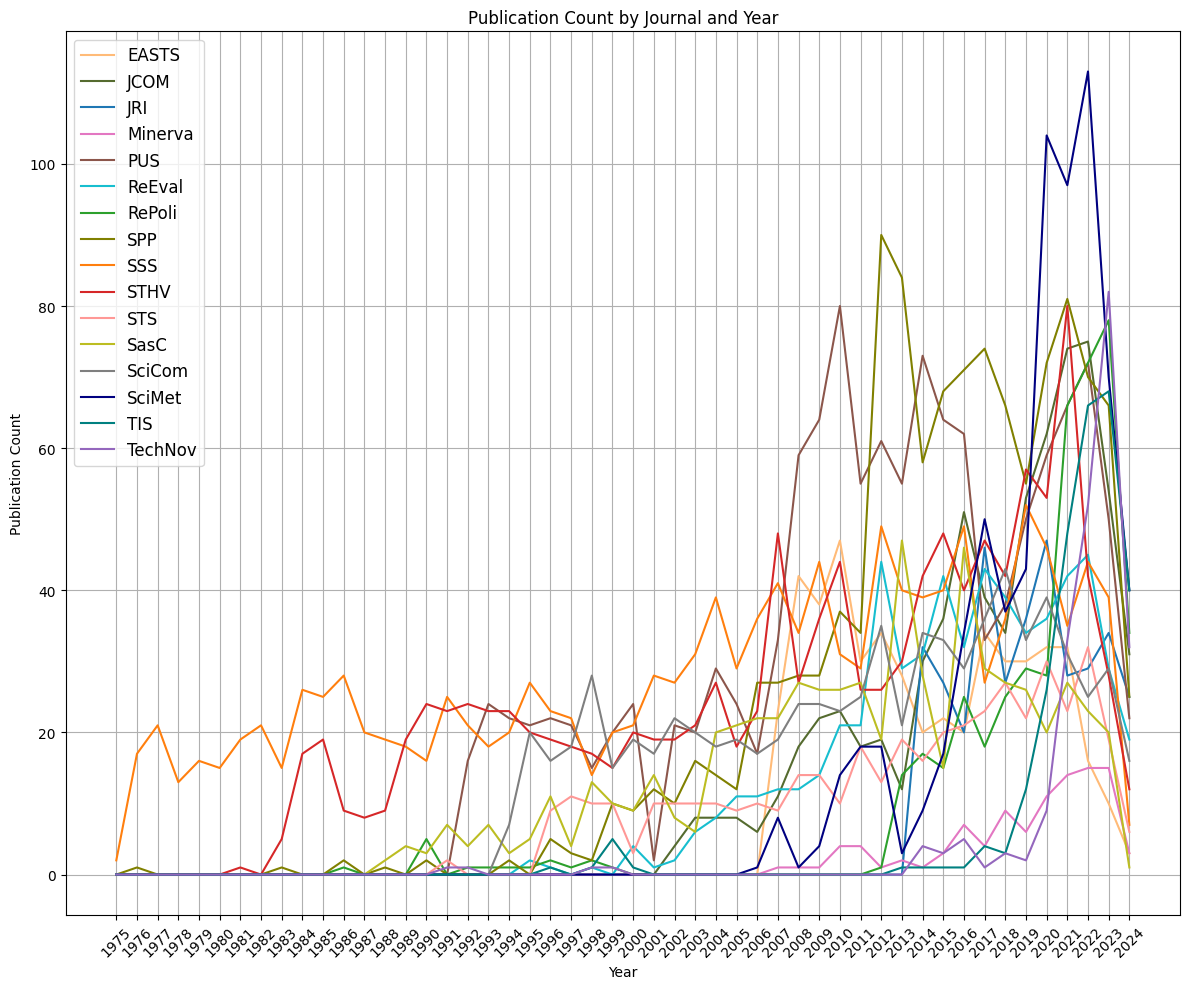

In [26]:
# ジャーナルでグループ化して年ごとの出版数を計算
journal_year_counts = df.groupby(['journal_name', 'publication_year']).size().unstack(fill_value=0)



# グラフのサイズを設定
plt.figure(figsize=(12, 10))  # 図のサイズを調整

# ジャーナルごとにループしてプロット
for journal in journal_year_counts.index:
    plt.plot(journal_year_counts.columns, journal_year_counts.loc[journal], label=journal, color=journal_colors.get(journal, 'k'))

# グラフのタイトルとラベルを設定
plt.title('Publication Count by Journal and Year')
plt.xlabel('Year')
plt.ylabel('Publication Count')

# 凡例の設定
plt.legend(loc='upper left', fontsize='large')  # 凡例を内側の左上に配置、フォントサイズをlargeに設定

# x軸を整数値に設定
plt.xticks(journal_year_counts.columns, rotation=45)

# グリッドを表示
plt.grid(True)

# グラフを表示
plt.tight_layout()
plt.show()


# 年ごとのトピックの種類の変化


*   フィールド/サブフィールドの変化
*   出版数と概ね相関しているので、徐々にトピックが減ったということはなさそう



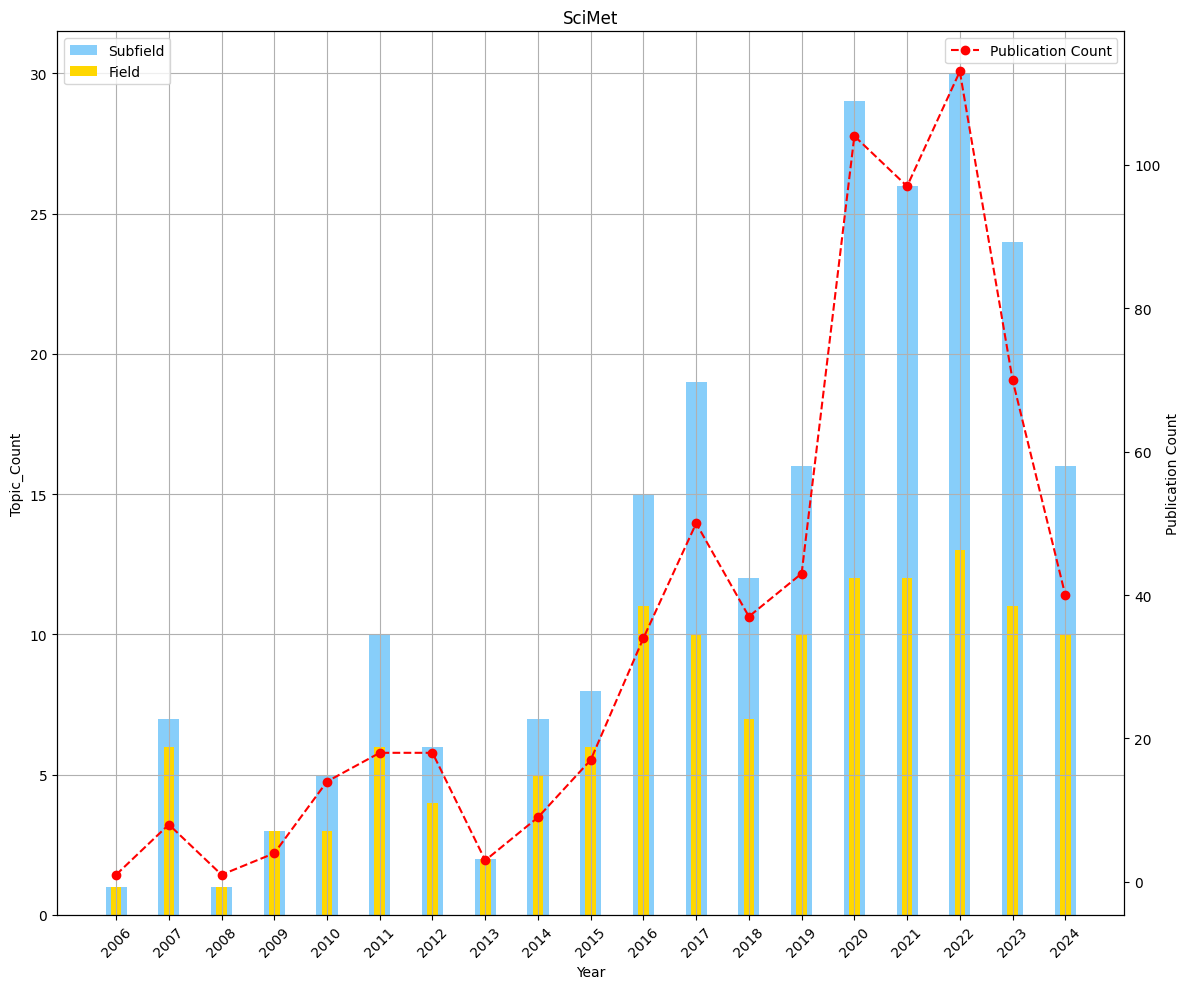

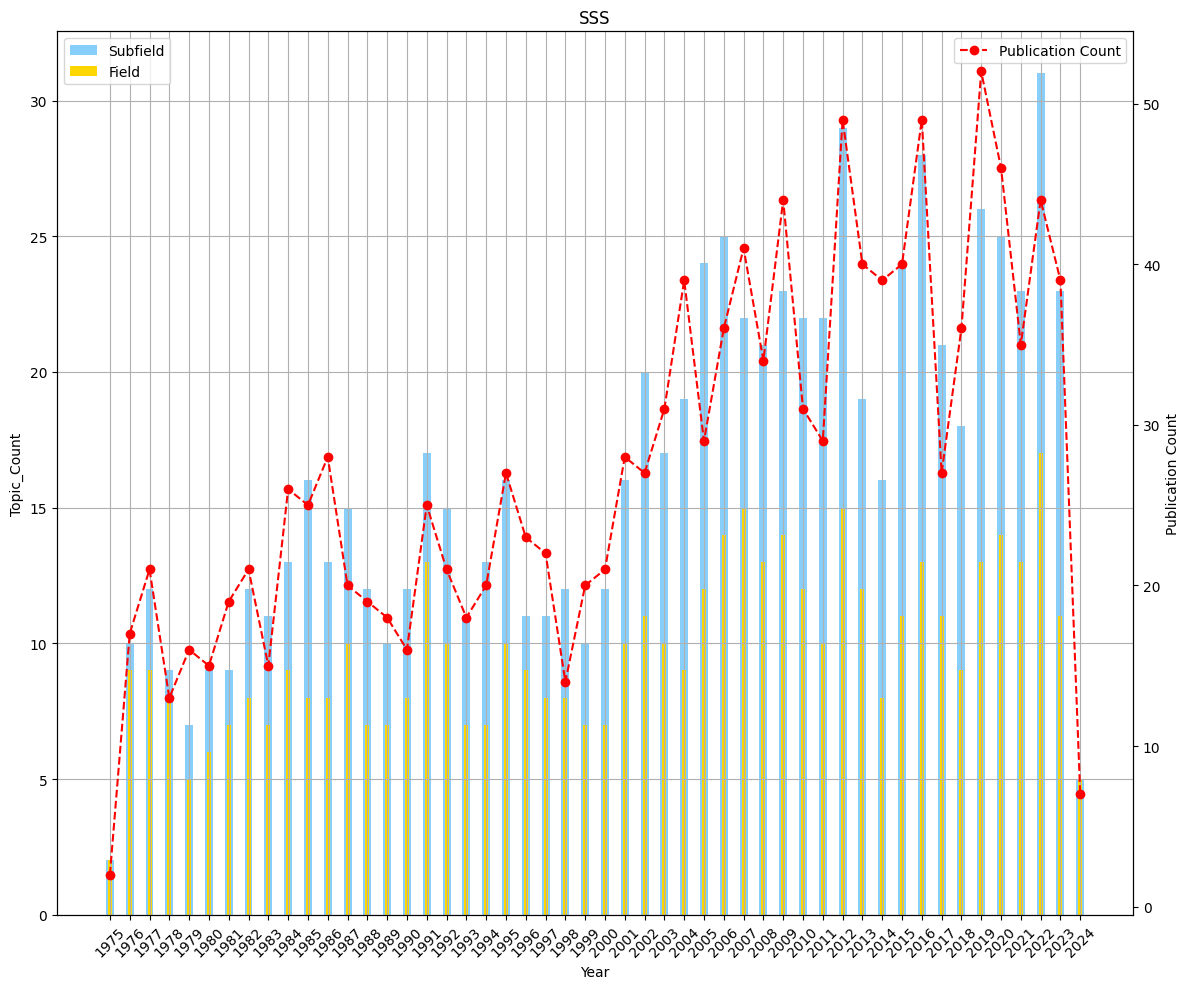

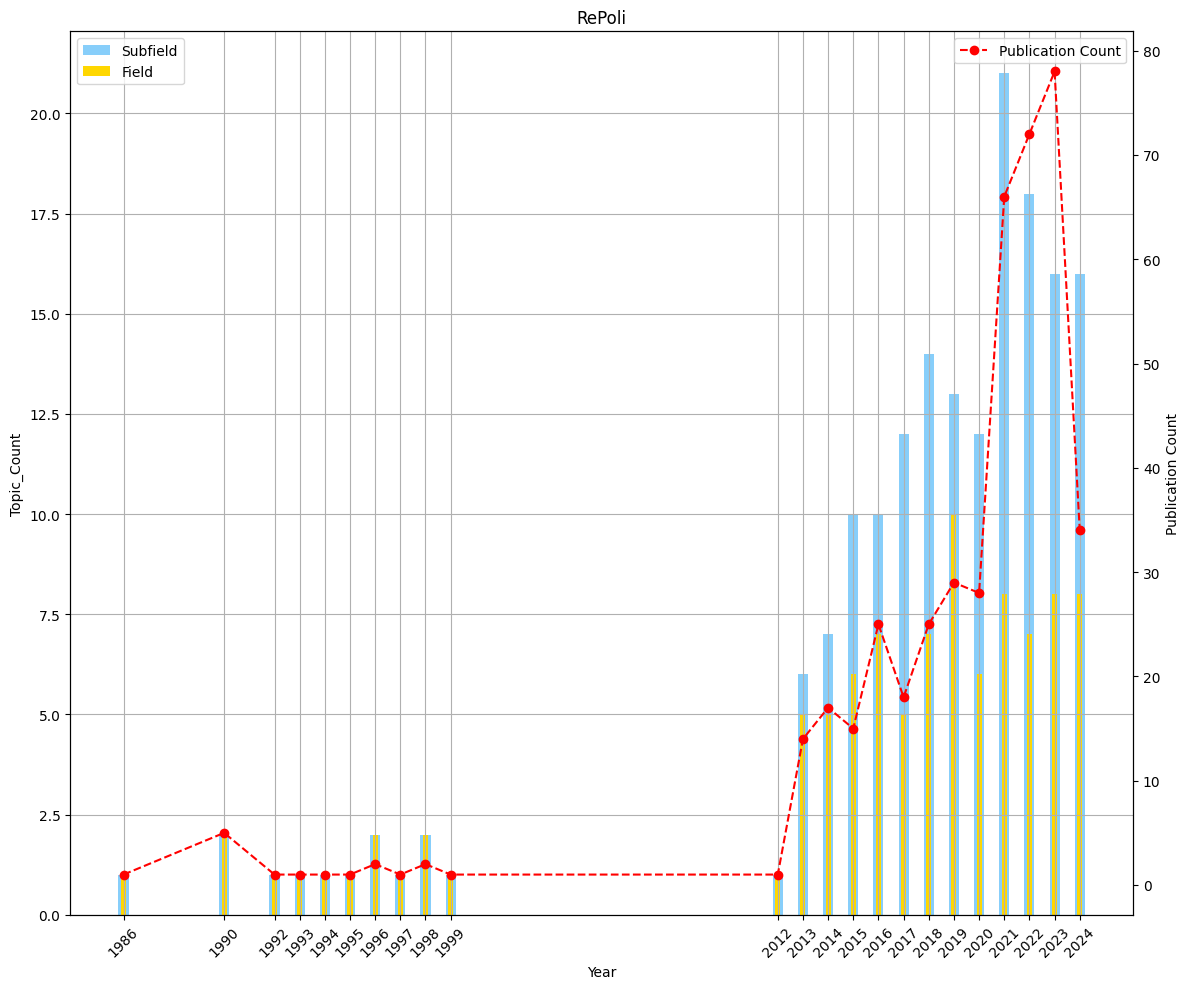

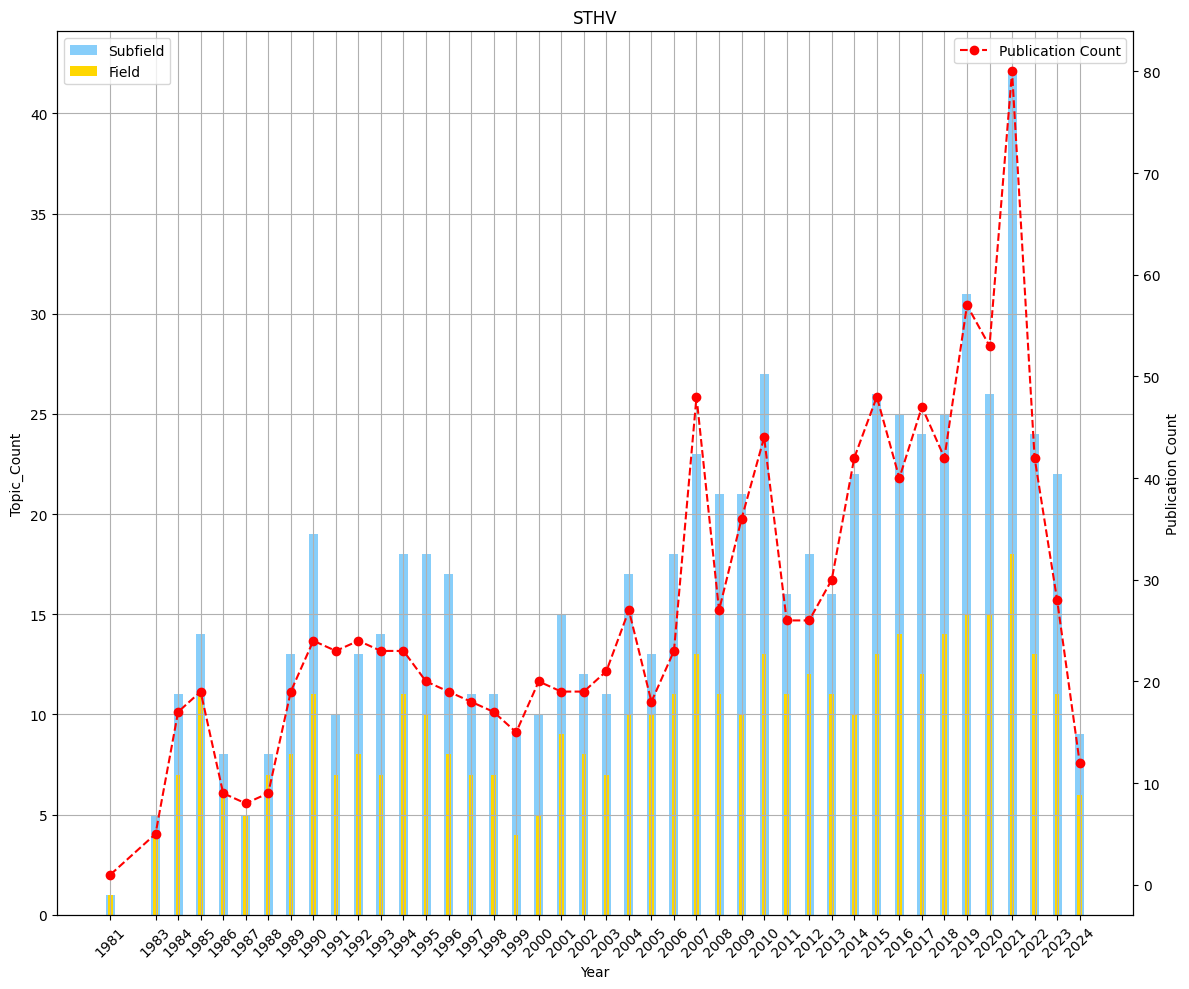

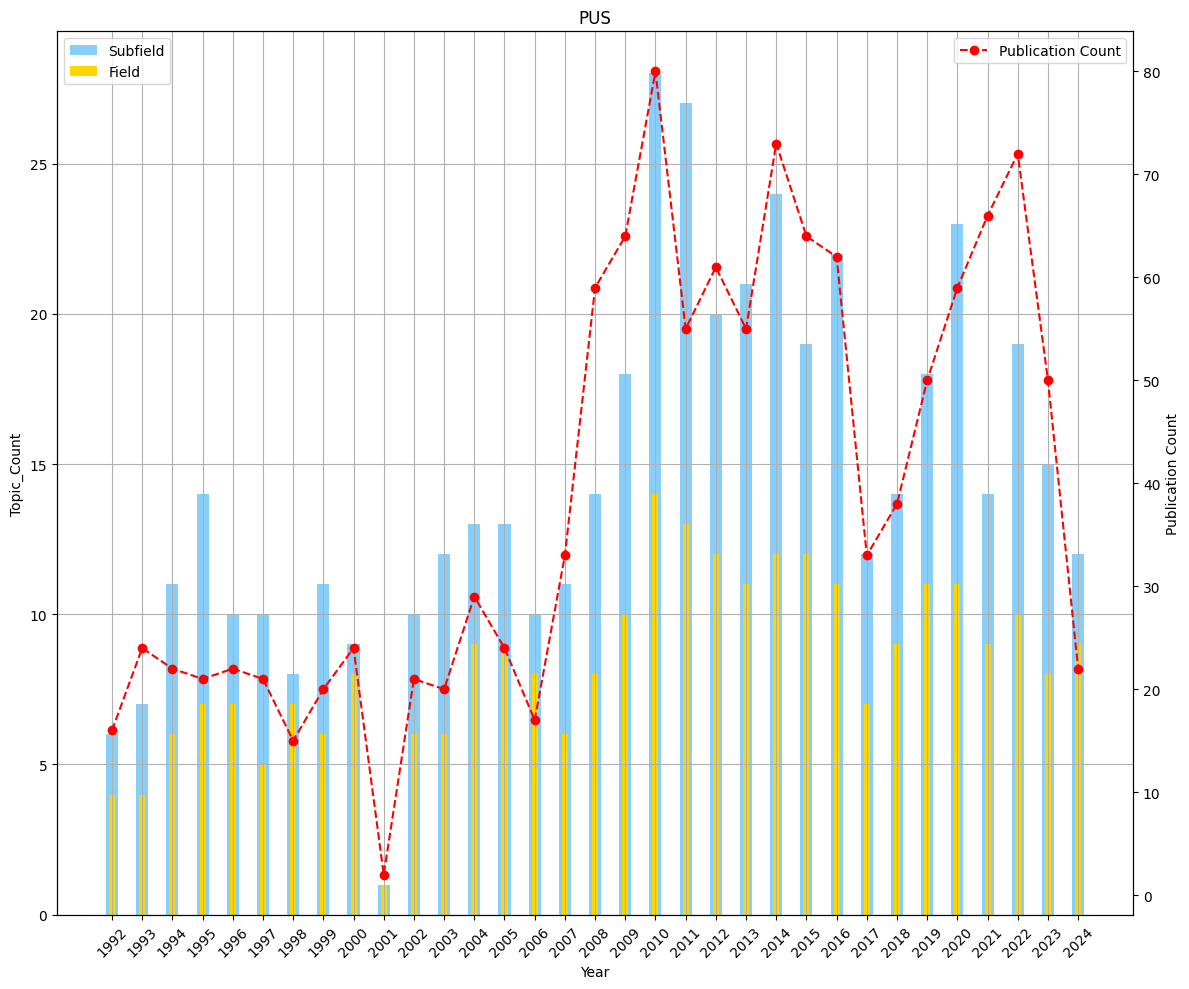

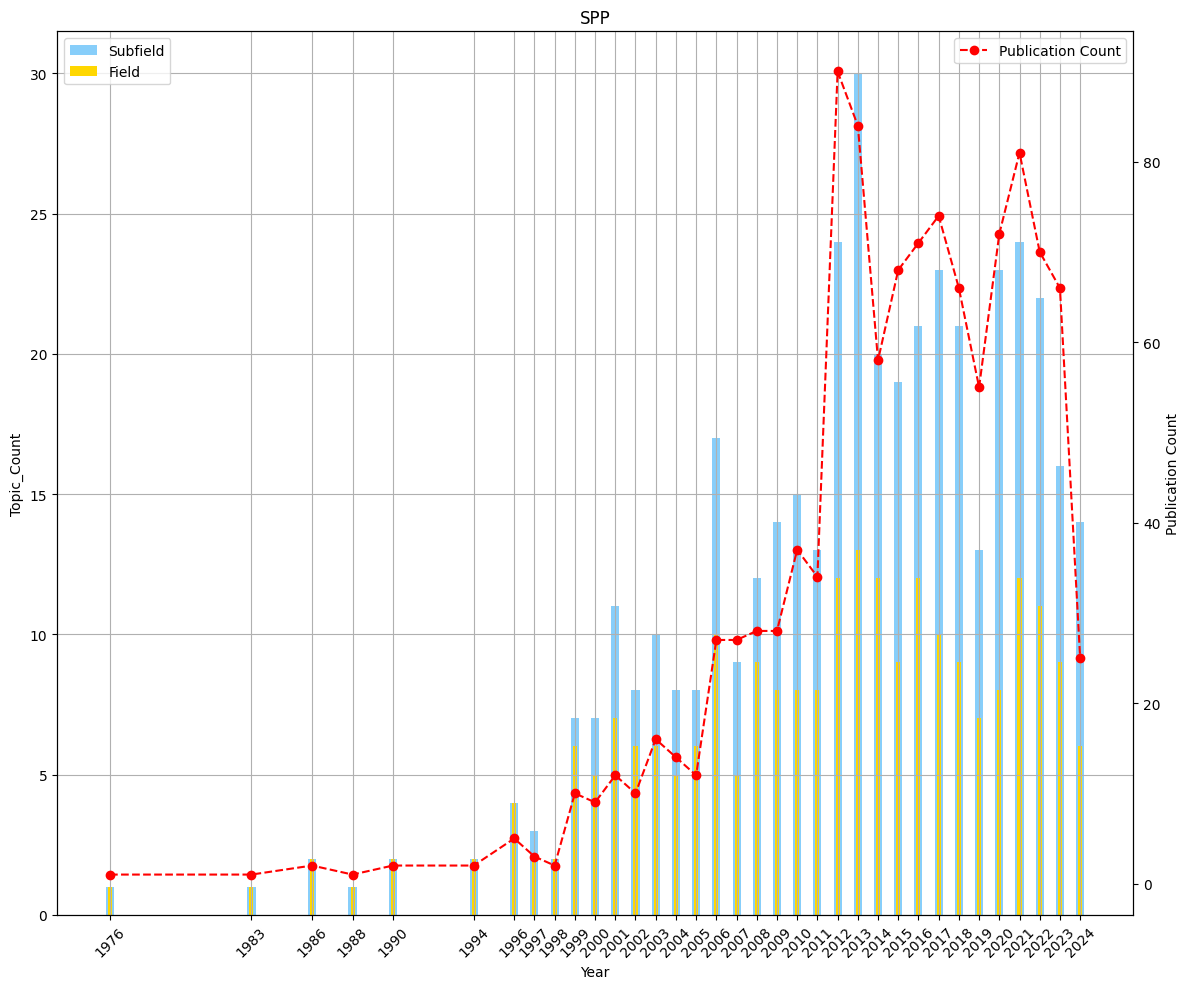

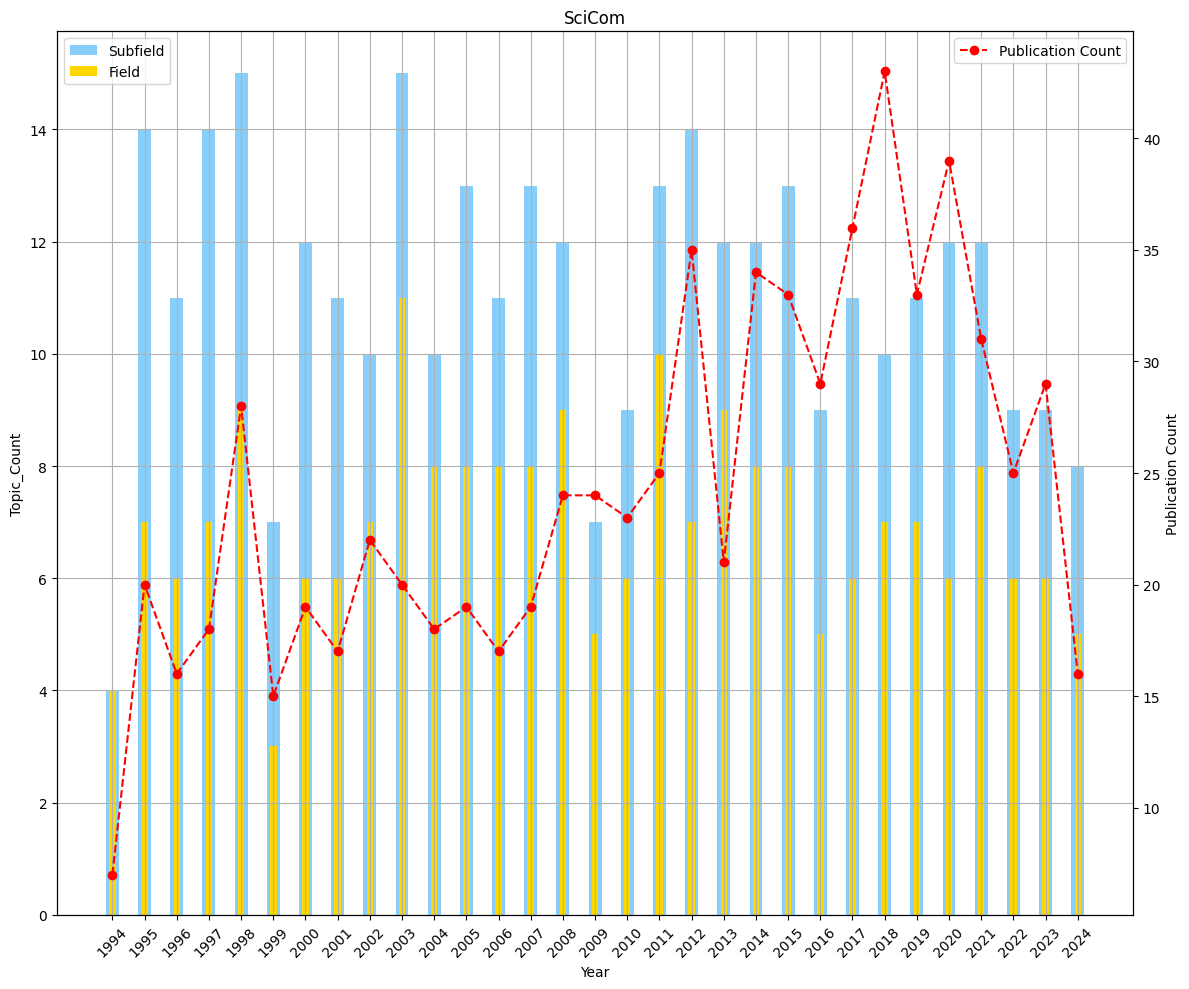

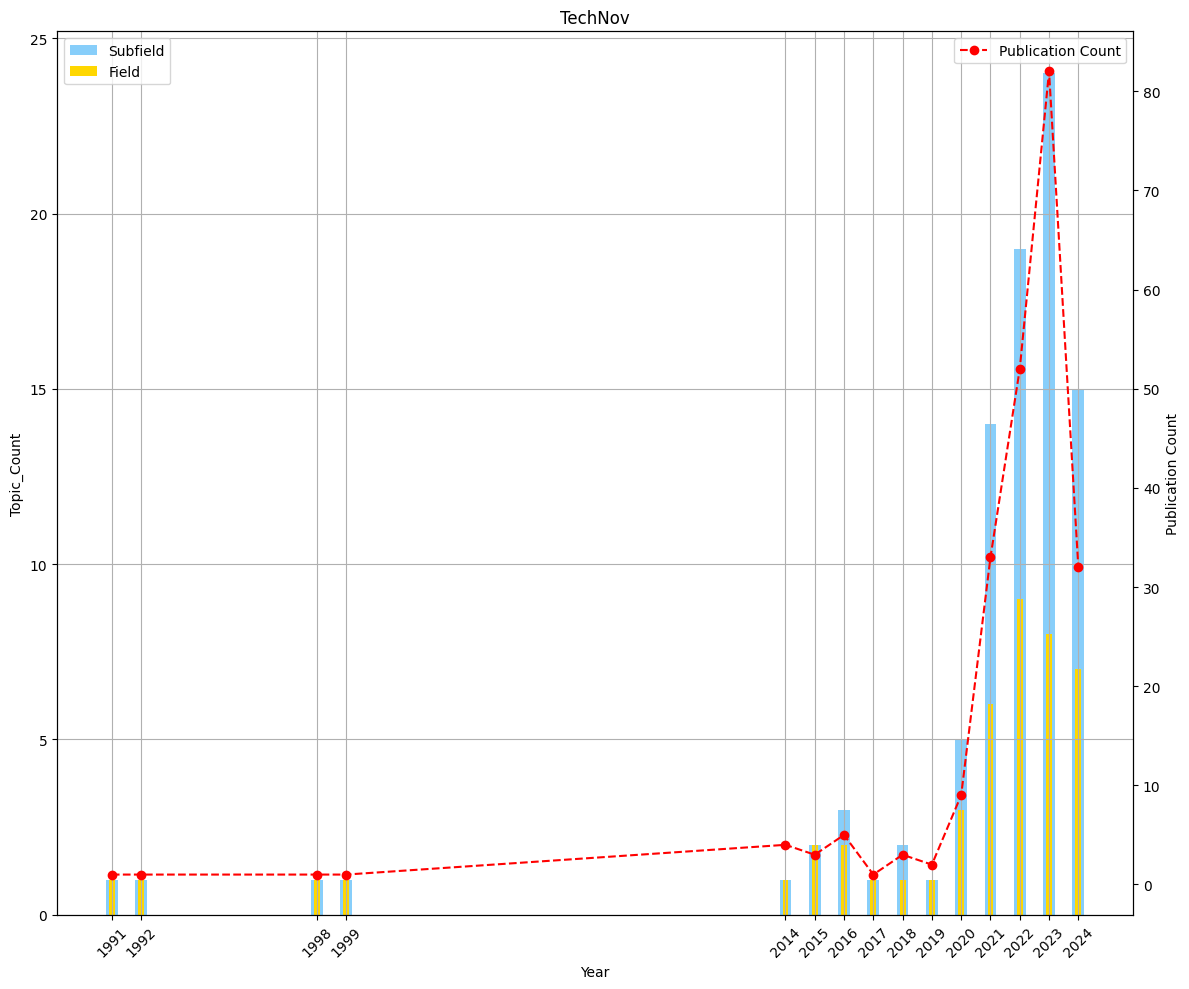

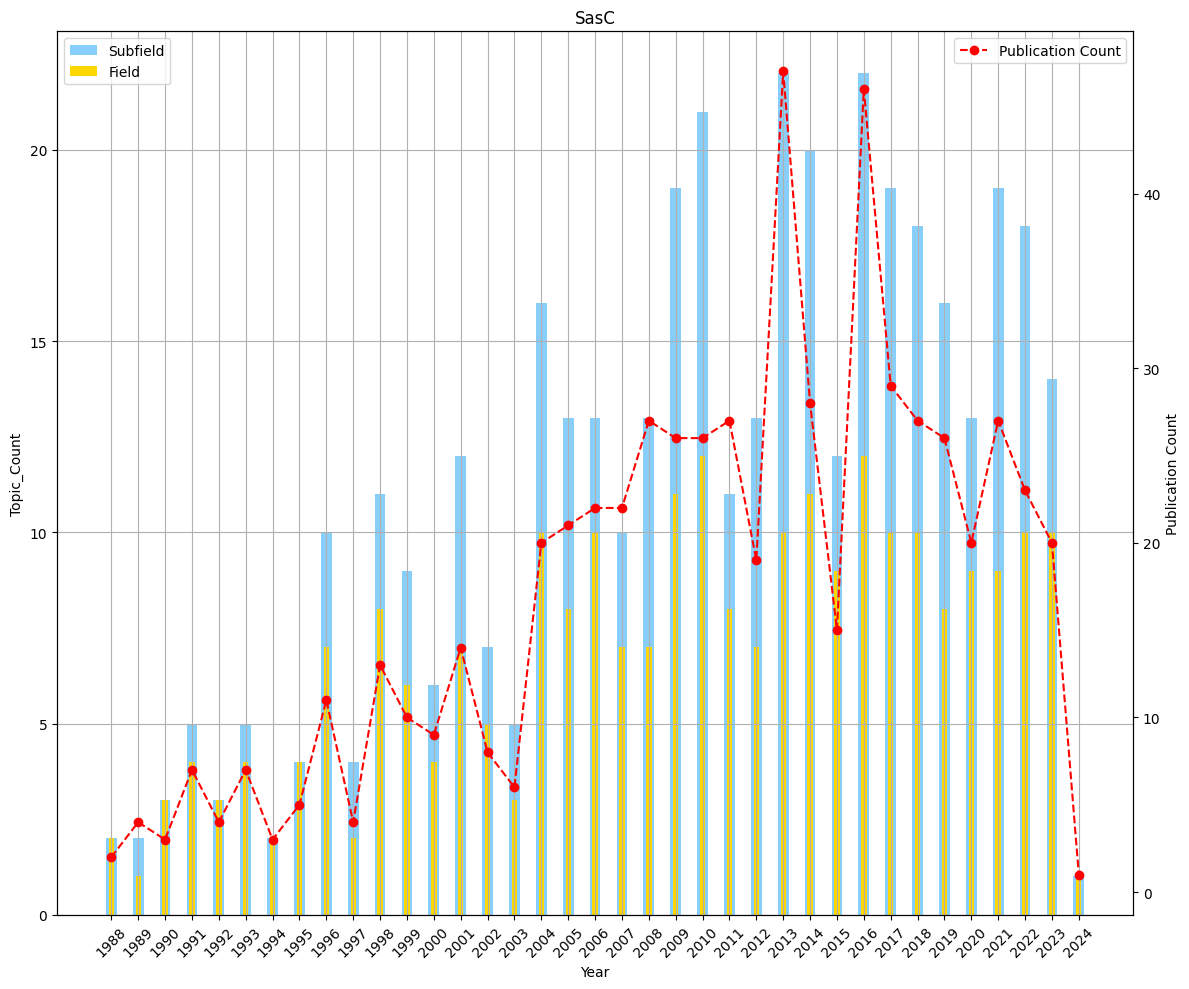

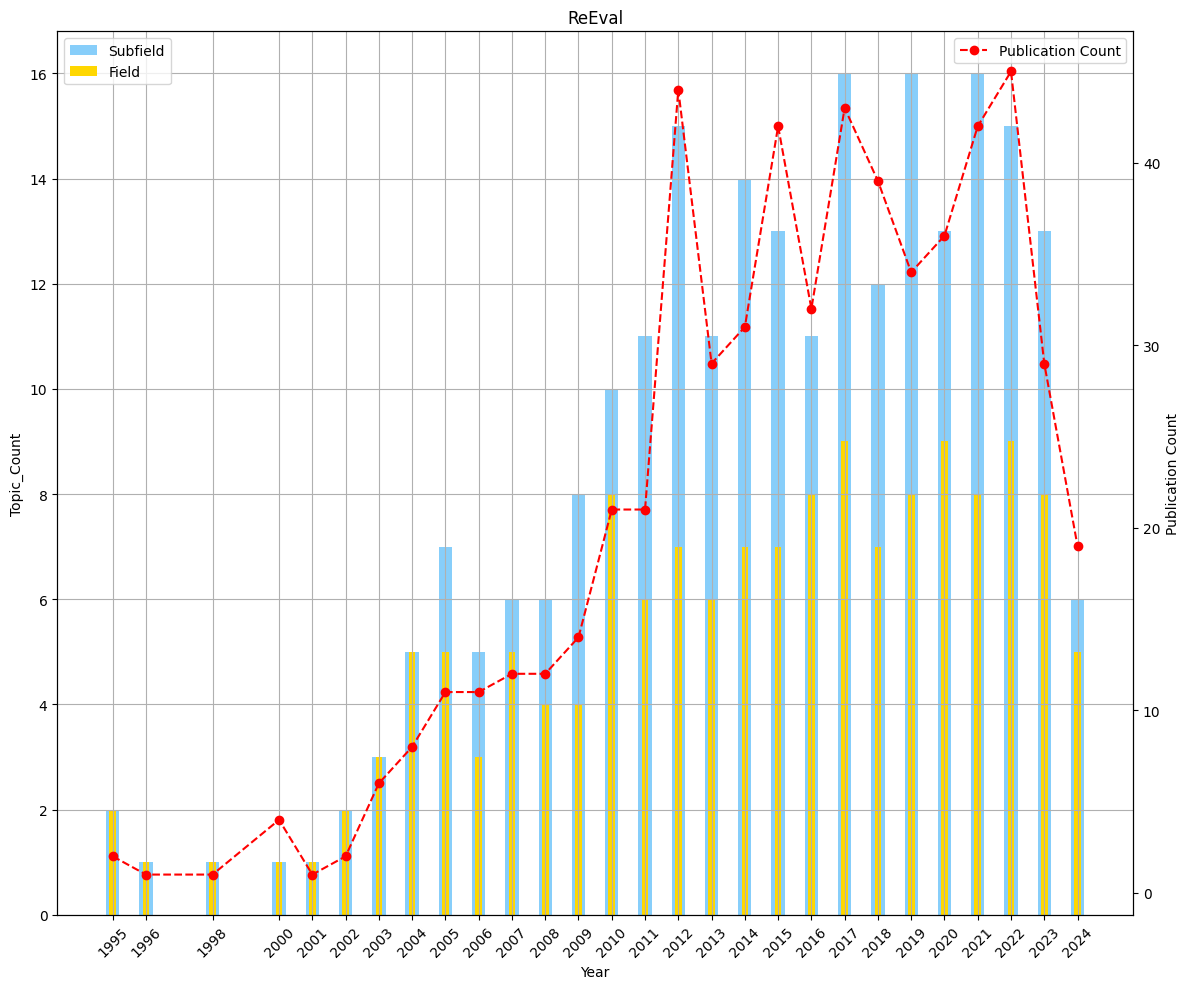

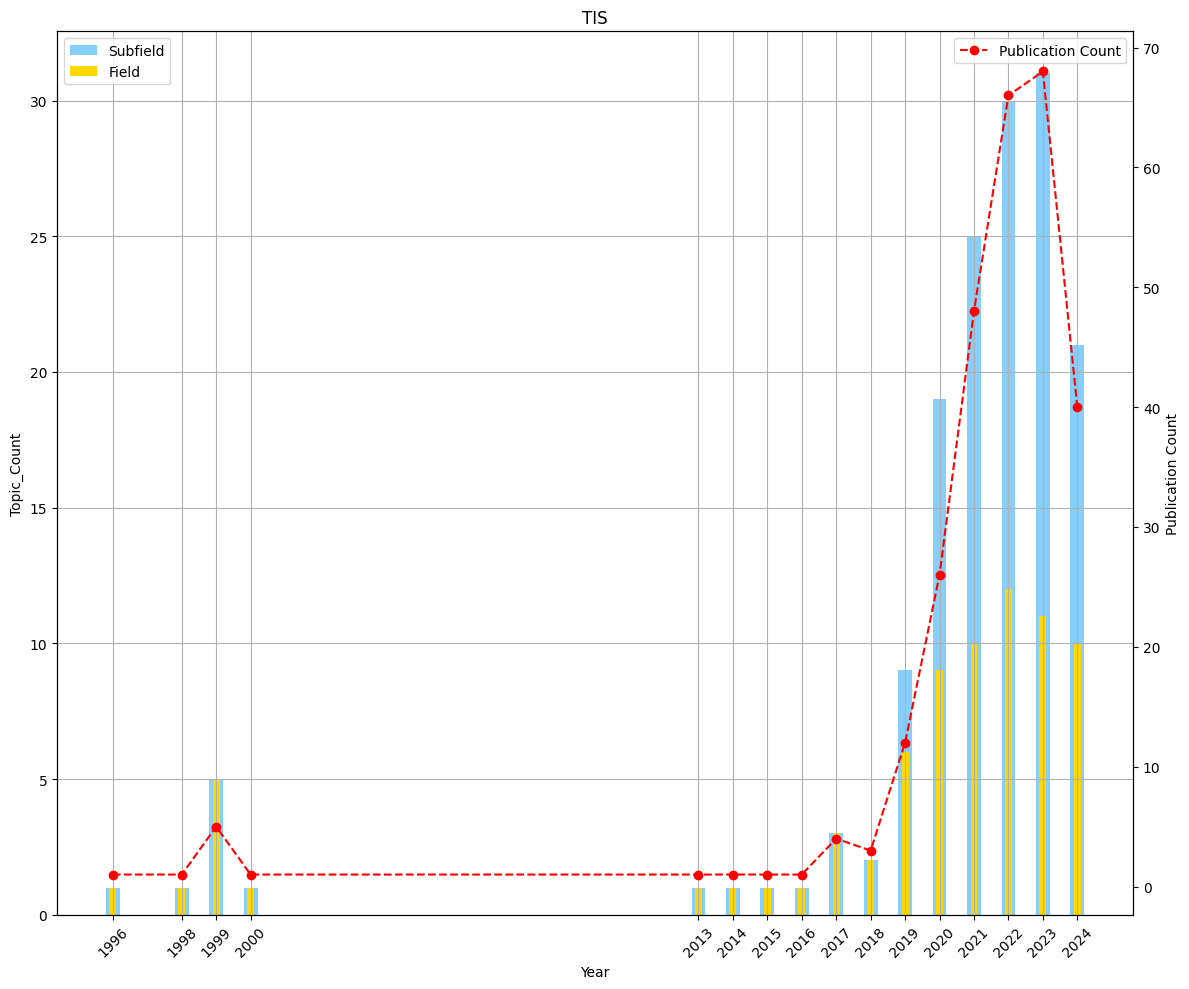

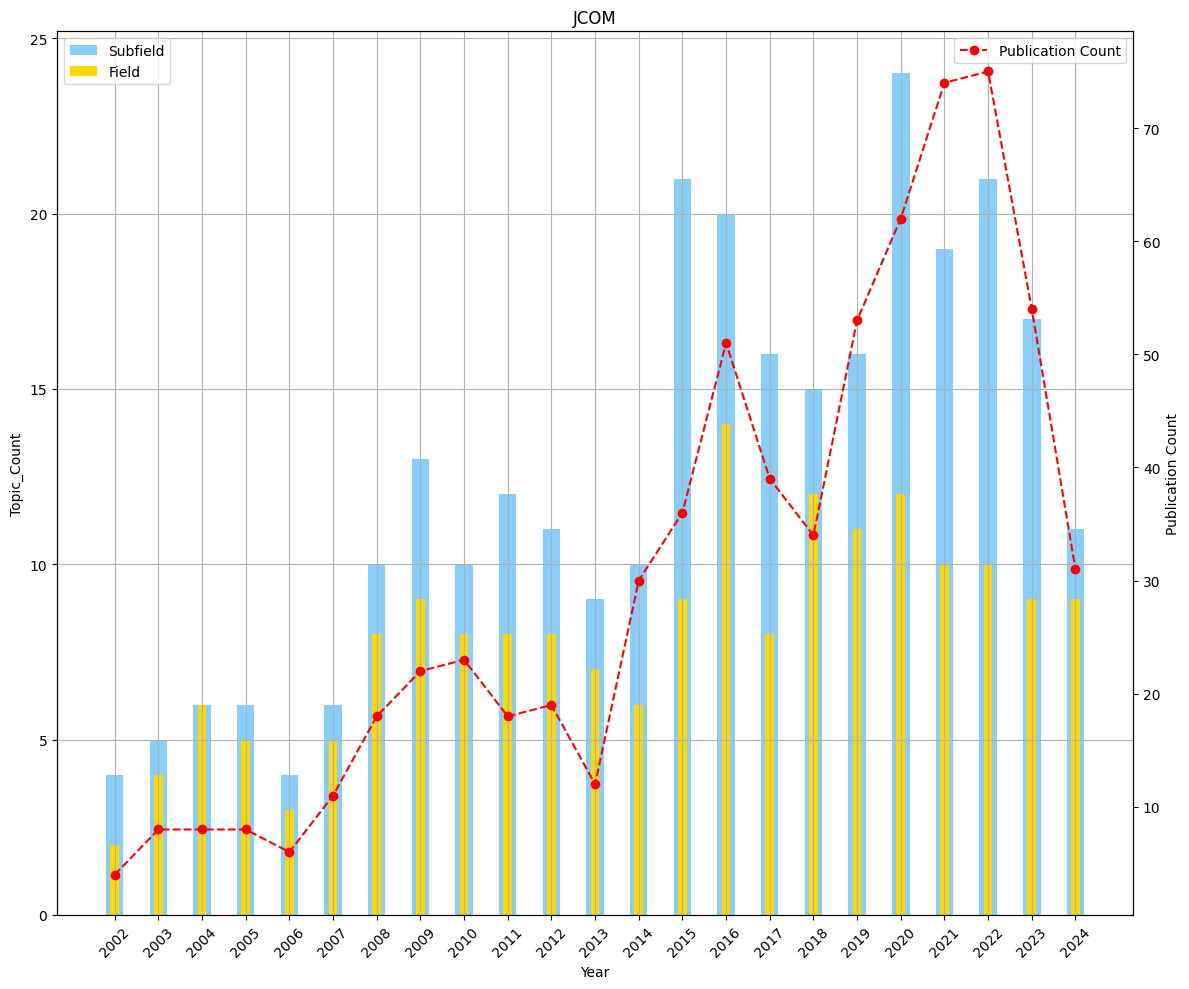

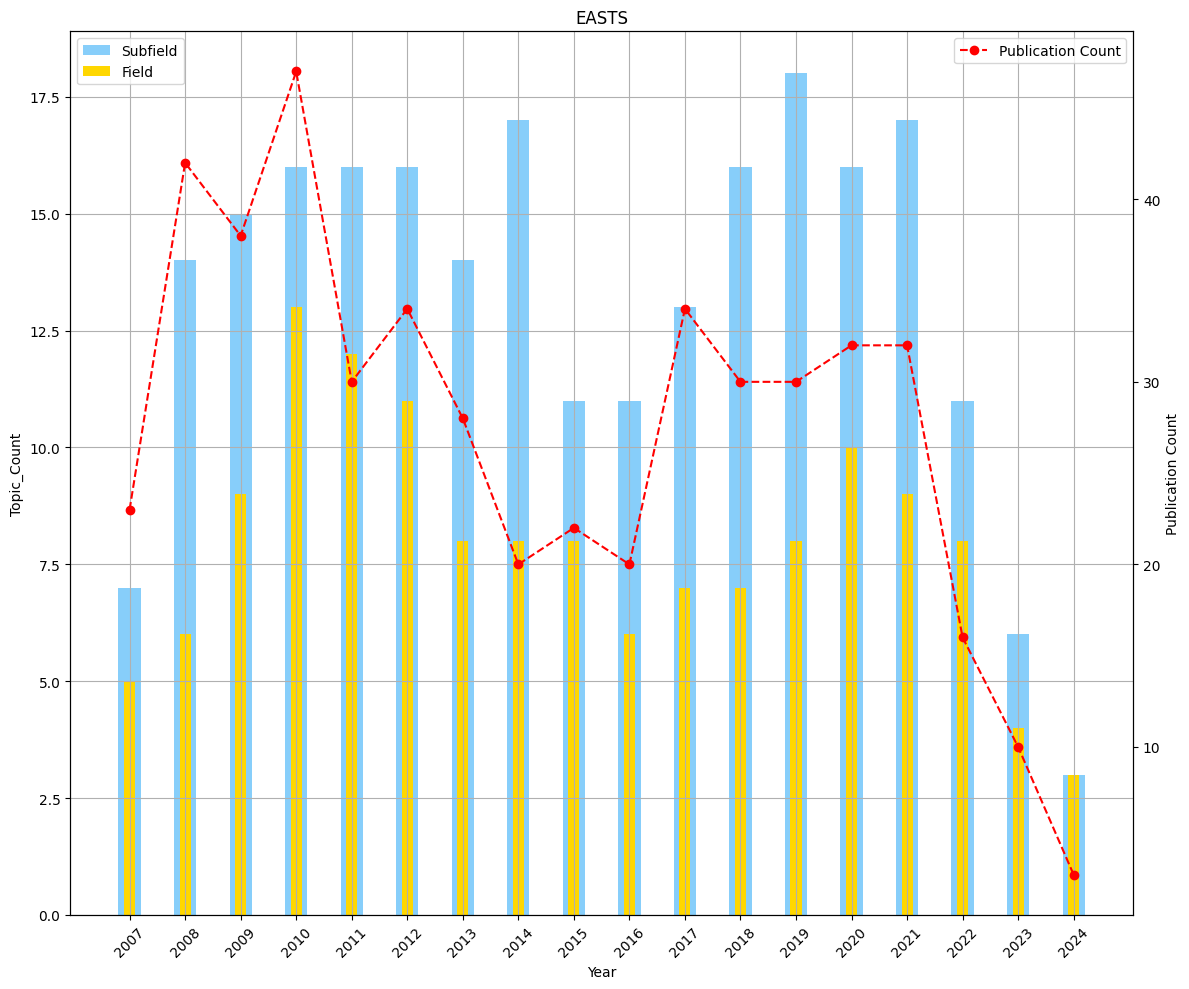

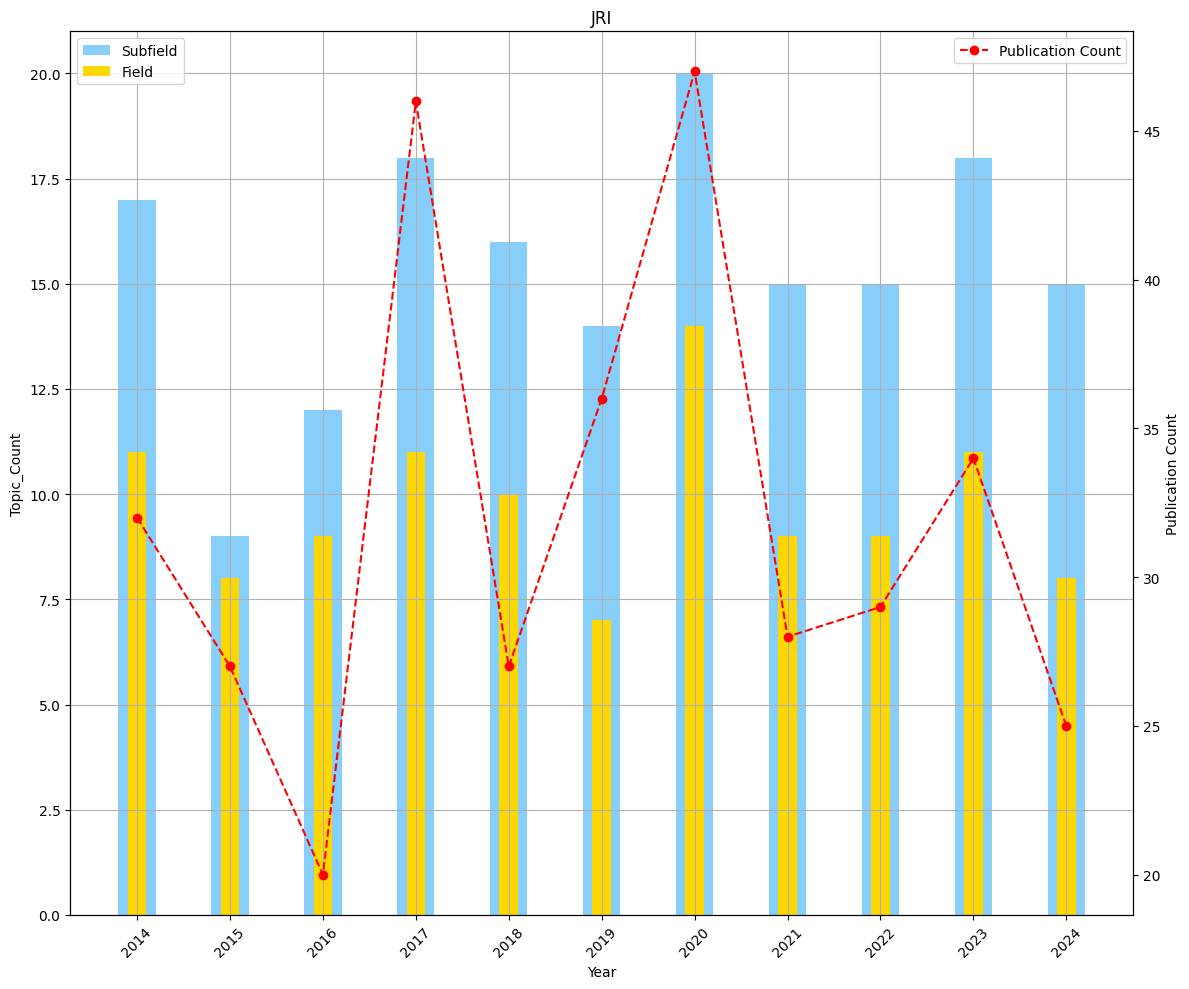

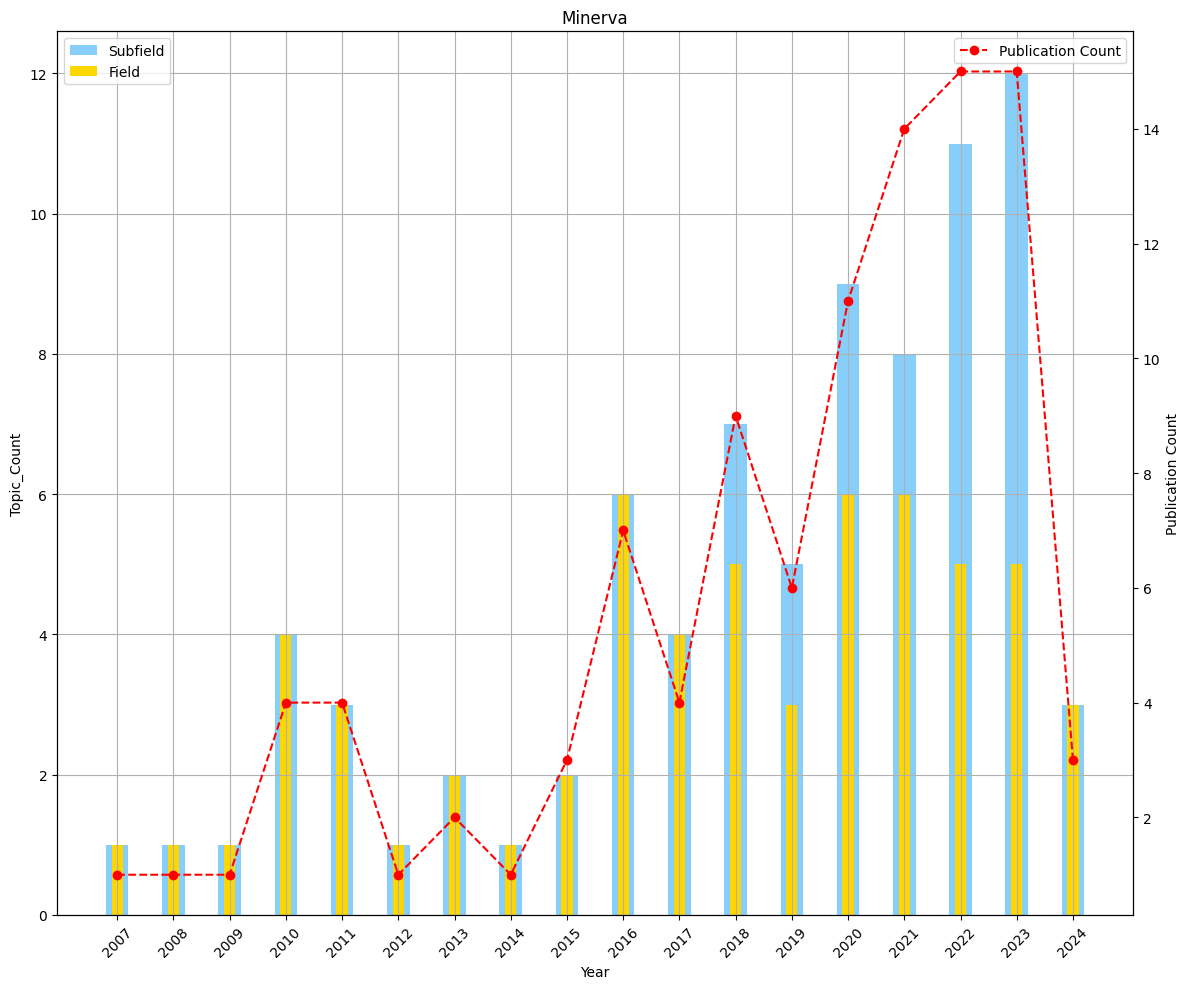

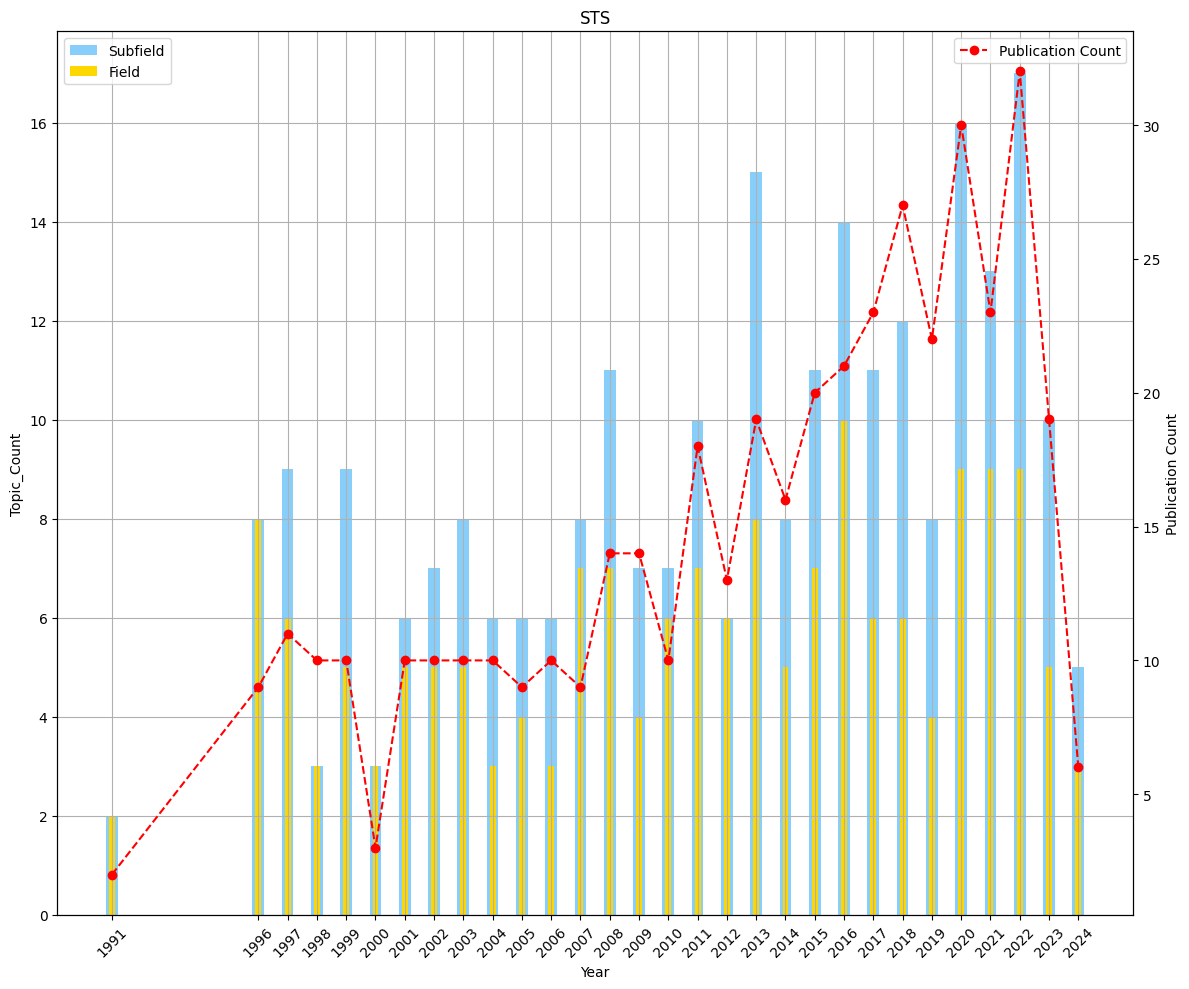

In [29]:
import matplotlib.pyplot as plt

# ジャーナルごとにイテレーション
for journal_name in df['journal_name'].unique():
    # ジャーナルごとにデータを抽出
    journal_data = df[df['journal_name'] == journal_name]

    # 年ごとにサブフィールドの数とフィールドの数を計算
    subfield_counts = journal_data.groupby('publication_year')['subfield'].nunique()
    field_counts = journal_data.groupby('publication_year')['field'].nunique()

    # 年ごとの総ジャーナル数を計算
    total_counts = journal_data.groupby('publication_year').size()

    # グラフのサイズを設定
    fig, ax1 = plt.subplots(figsize=(12, 10))

    # サブフィールド数とフィールド数のプロットを棒グラフで
    ax1.bar(subfield_counts.index, subfield_counts.values , width=0.4, align='center', label='Subfield', color='lightskyblue')
    ax1.bar(field_counts.index, field_counts.values, width=0.2, align='center', label='Field', color='gold')

    # 出版数のプロット（点線）
    ax2 = ax1.twinx()
    ax2.plot(total_counts.index, total_counts.values, marker='o', linestyle='--', label='Publication Count', color='red')

    # グラフのタイトルとラベルを設定
    plt.title(f'{journal_name}')
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Topic_Count')
    ax2.set_ylabel('Publication Count')

    # 凡例を表示
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

    # x軸を整数値に設定し、45度回転させる
    ax1.set_xticks(subfield_counts.index)
    ax1.set_xticklabels(subfield_counts.index, rotation=45)

    # グリッドを表示
    ax1.grid(True)

    # グラフを表示
    plt.tight_layout()
    plt.show()


# サブジャンルを指標にした類似度


*   サブジャンルの組成をベクトル化
*   リスト項目



In [30]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# サブフィールドの組成をベクトルとして表現する関数
def get_subfield_vector(subfield_counts, subfield_list):
    vector = np.zeros(len(subfield_list))
    for i, subfield in enumerate(subfield_list):
        if subfield in subfield_counts:
            vector[i] = subfield_counts[subfield]
    return vector

# ジャーナル間の類似度を計算する関数
def calculate_similarity(journal_data1, journal_data2, subfield_list):
    # ジャーナルごとのサブフィールドの出現頻度を計算
    subfield_counts1 = journal_data1['subfield'].value_counts().to_dict()
    subfield_counts2 = journal_data2['subfield'].value_counts().to_dict()

    # ジャーナルごとのサブフィールドのベクトルを取得
    vector1 = get_subfield_vector(subfield_counts1, subfield_list)
    vector2 = get_subfield_vector(subfield_counts2, subfield_list)

    # コサイン類似度を計算
    similarity = cosine_similarity([vector1], [vector2])[0][0]
    return similarity


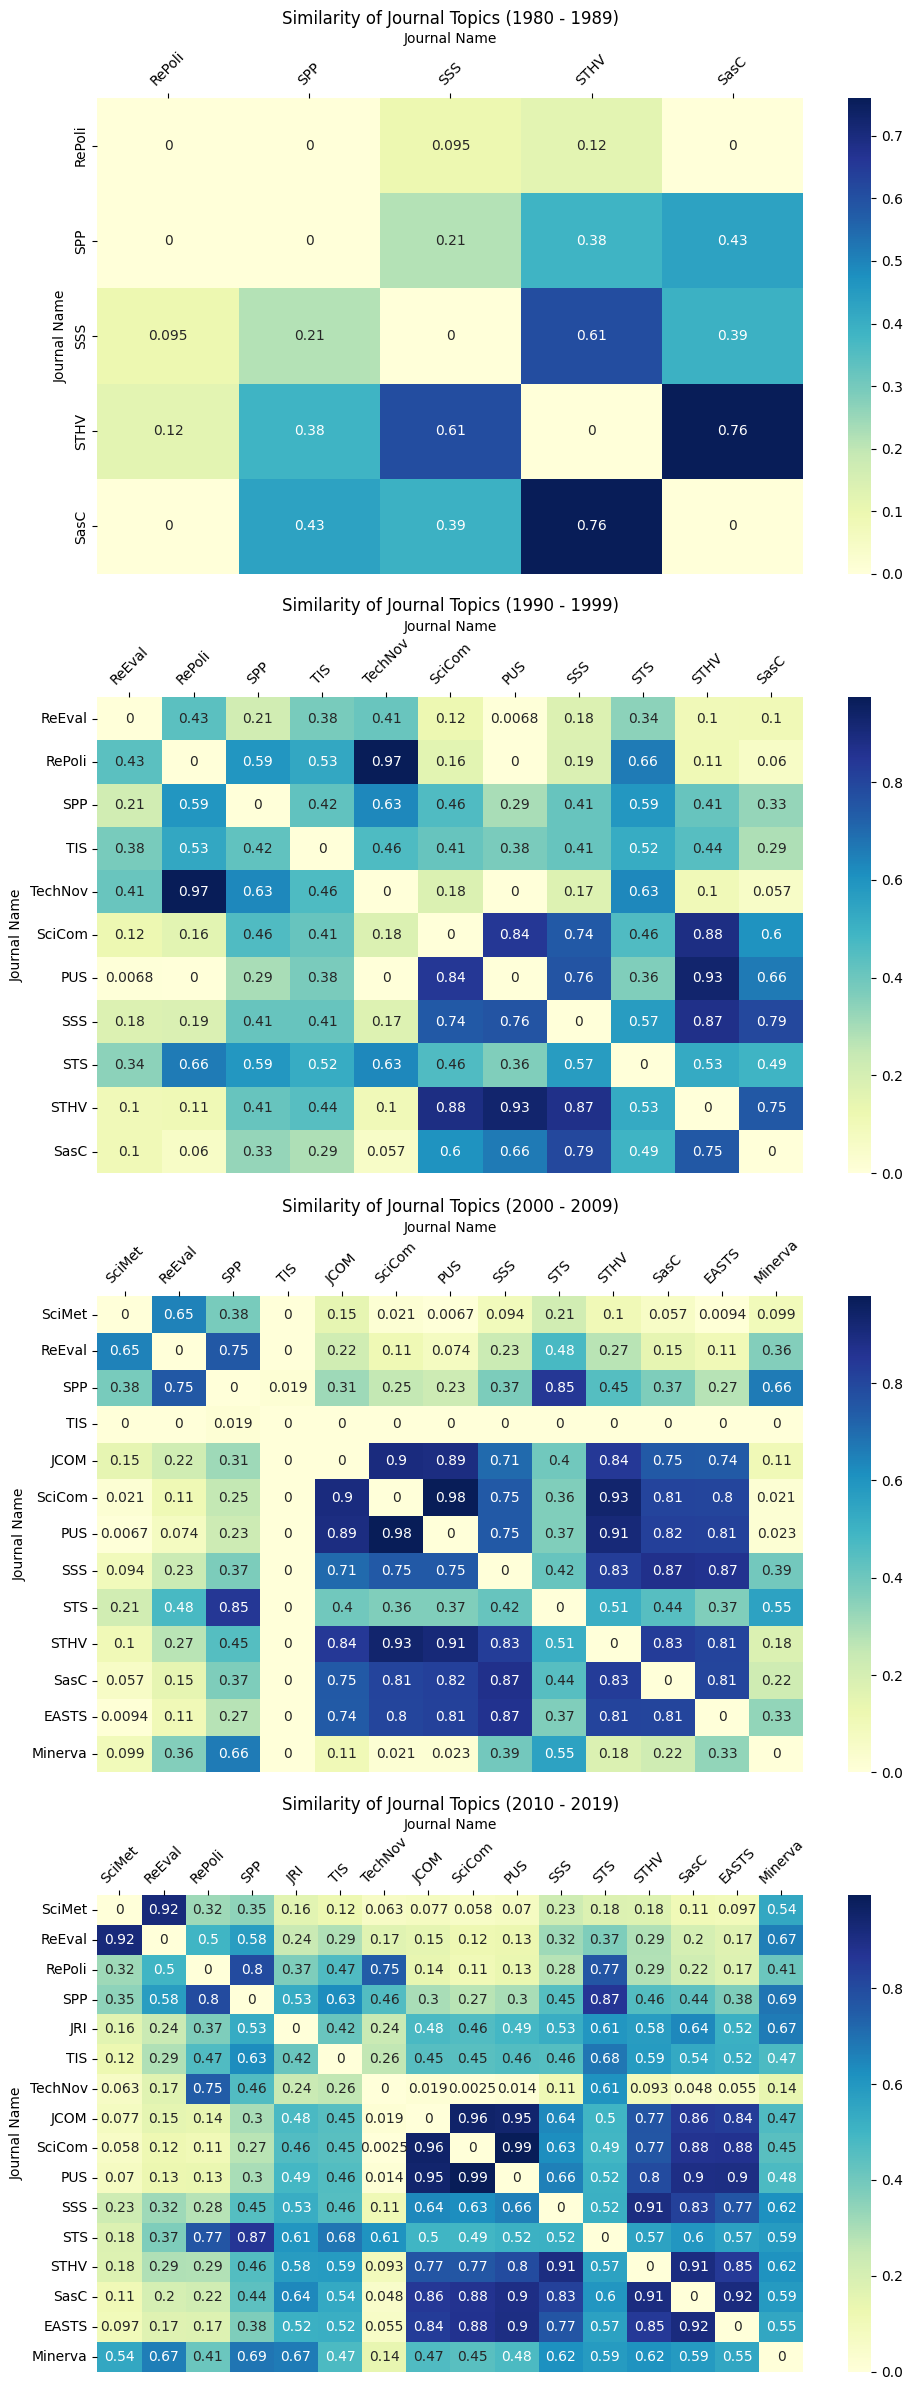

In [33]:
lst =['SciMet','ReEval','RePoli','SPP',
 'JRI','TIS','TechNov',
 'JCOM','SciCom','PUS',
 'SSS','STS','STHV','SasC','EASTS','Minerva']

import seaborn as sns

# サブフィールドのリストを取得
subfield_list = df['subfield'].unique()

# 10年ごとのジャーナル間の類似度を計算
years = range(1980, 2020, 10)
fig, axes = plt.subplots(nrows=len(years), ncols=1, figsize=(10, 6 * len(years)))

for i, year in enumerate(years):
    # 10年ごとのジャーナルデータを取得
    journal_data = df[df['publication_year'].between(year, year + 9)]

    # ジャーナル名を抽出
    journal_names = journal_data['journal_name'].unique()
    journal_names = [name for name in lst if name in journal_names]

    # ジャーナル間の類似度行列を作成
    similarity_matrix = np.zeros((len(journal_names), len(journal_names)))
    for j, journal1 in enumerate(journal_names):
        for k, journal2 in enumerate(journal_names):
            if j != k:
                # ジャーナル間の類似度を計算
                similarity = calculate_similarity(journal_data[journal_data['journal_name'] == journal1],
                                                  journal_data[journal_data['journal_name'] == journal2],
                                                  subfield_list)
                similarity_matrix[j, k] = similarity

    # ヒートマップの描画
    sns.heatmap(similarity_matrix, ax=axes[i], cmap="YlGnBu", annot=True, xticklabels=[name for name in journal_names], yticklabels=[name for name in journal_names])
    axes[i].set_title(f'Similarity of Journal Topics ({year} - {year + 9})')
    axes[i].set_xlabel('Journal Name')
    axes[i].set_ylabel('Journal Name')
    axes[i].tick_params(axis='x', labelrotation=45)  # x軸のジャーナル名を45度回転

    # x軸を図の上側に配置
    axes[i].xaxis.tick_top()
    axes[i].xaxis.set_label_position('top')

plt.tight_layout()
plt.show()


# 被引用数の推移

何も言えない

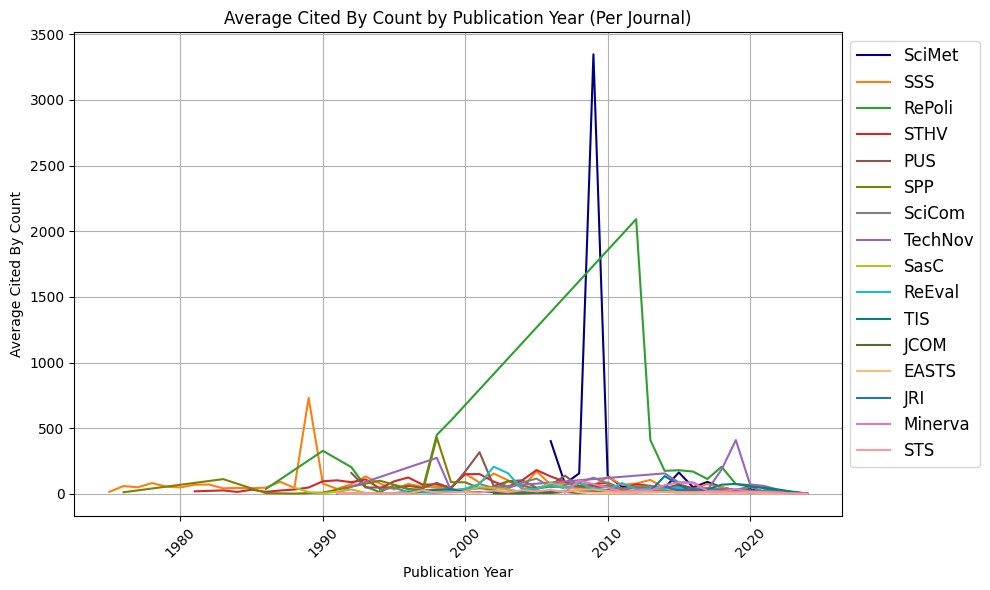

In [34]:

import matplotlib.pyplot as plt

# ジャーナルごとにイテレーション
journals = df['journal_name'].unique()
plt.figure(figsize=(10, 6))

for journal_name in journals:
    # ジャーナルごとにデータを抽出
    journal_data = df[df['journal_name'] == journal_name]

    # 年ごとのcited_by_countの平均を計算
    yearly_mean_cited_by_count = journal_data.groupby('publication_year')['cited_by_count'].mean()

    # プロット
    plt.plot(yearly_mean_cited_by_count.index, yearly_mean_cited_by_count.values, label=journal_name, color=journal_colors.get(journal_name, 'black'))

# グラフのタイトルとラベルを設定
plt.title('Average Cited By Count by Publication Year (Per Journal)')
plt.xlabel('Publication Year')
plt.ylabel('Average Cited By Count')

# 凡例の設定
plt.legend(loc='upper left', fontsize='large', bbox_to_anchor=(1, 1))

# x軸を整数値に設定し、45度回転
plt.xticks(rotation=45)

# グリッドを表示
plt.grid(True)

# グラフを表示
plt.tight_layout()
plt.show()

# 参考文献の数の推移

先行研究通り増加している

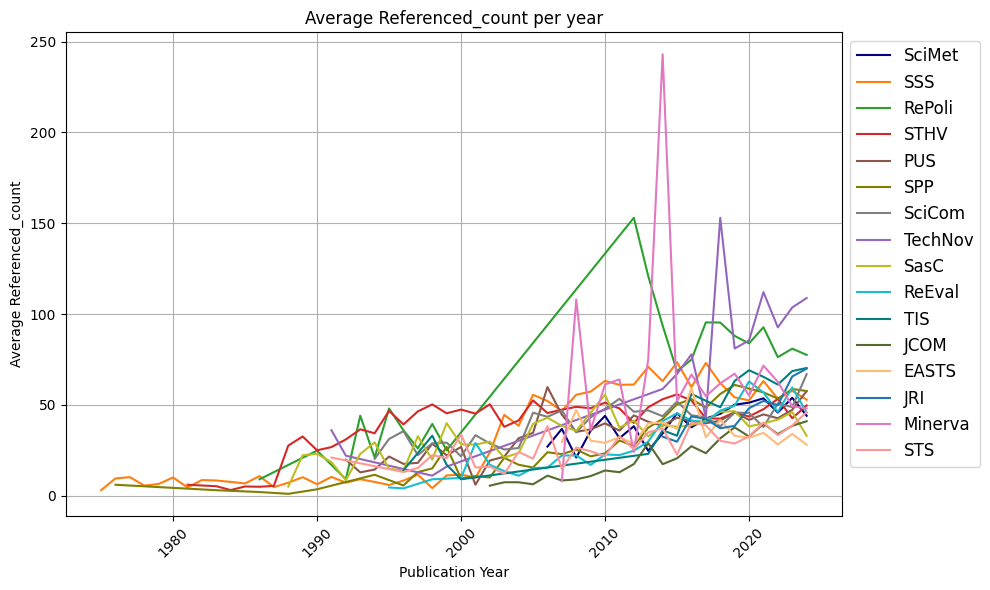

In [35]:
import matplotlib.pyplot as plt

# ジャーナルごとにイテレーション
journals = df['journal_name'].unique()
plt.figure(figsize=(10, 6))

for journal_name in journals:
    # ジャーナルごとにデータを抽出
    journal_data = df[df['journal_name'] == journal_name]


    # 年ごとのcited_by_countの平均を計算
    yearly_mean_referenced_count = journal_data.groupby('publication_year')['referenced_count'].mean()

    # プロット
    plt.plot(yearly_mean_referenced_count.index, yearly_mean_referenced_count.values, label=journal_name, color=journal_colors.get(journal_name, 'black'))

# グラフのタイトルとラベルを設定
plt.title('Average Referenced_count per year')
plt.xlabel('Publication Year')
plt.ylabel('Average Referenced_count')

# 凡例の設定
plt.legend(loc='upper left', fontsize='large', bbox_to_anchor=(1, 1))

# x軸を整数値に設定し、45度回転
plt.xticks(rotation=45)

# グリッドを表示
plt.grid(True)

# グラフを表示
plt.tight_layout()
plt.show()
